In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv as csv
import networkx as nx
import pandas as pd
from tqdm import tqdm

import csv

import os

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import left_right_task as lrt, network_model

In [2]:
# move up two directories to access the data

os.chdir(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
os.chdir('model')
print(f"Current working directory: {os.getcwd()}")

Current working directory: c:\Users\caele\Documents\miller-lab-final\model


In [3]:
# load fiducial_network.csv
id, reliability, pset, amp, dur, l_kernel, r_kernel = tuple(pd.read_csv('fiducial_network.csv'))
Wji = np.load(f'Wji_{id}.npy')

str_to_arr = lambda s, d: np.array([float(x) for x in s.removeprefix('[').removesuffix(']').split(d)])

# print all
print(f"id: {id}")
reliability = float(reliability)
print(f"reliability: {reliability}")
pset = str_to_arr(pset, None)
print(f"pset: {pset}")
amp = float(amp)
print(f"amp: {amp}")
dur = float(dur)
print(f"dur: {dur}")
l_kernel = str_to_arr(l_kernel, ',')
r_kernel = str_to_arr(r_kernel, ',')
print(f"l_kernel: {l_kernel}")
print(f"r_kernel: {r_kernel}")

id: 725
reliability: 1.0
pset: [ 1.00000000e-02  1.00000000e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.19792554e+01  4.36437108e+01 -4.75062770e+00 -1.03428554e+01
  7.39000000e+00  1.04790000e+02]
amp: 10.12
dur: 0.001
l_kernel: [0.64043 1.24114 1.14783 1.18245 0.78815]
r_kernel: [0.22043 0.76899 0.75818 2.74219 0.51021]


In [4]:
numPairs = Wji.shape[-1]
print(f"numPairs: {numPairs}")
dt = 1e-5

numPairs: 5


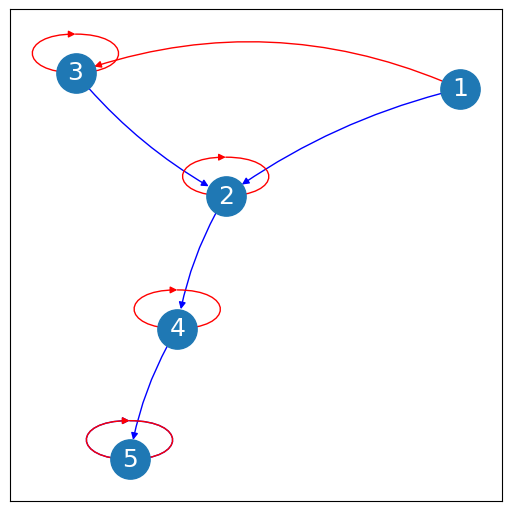

reliability: 1.0


In [5]:
l_stim = np.ones((numPairs)) * amp * l_kernel
l_stim = np.repeat(l_stim[:, np.newaxis], int(dur/dt), axis=1)
r_stim = np.ones((numPairs)) * amp * r_kernel
r_stim = np.repeat(r_stim[:, np.newaxis], int(dur/dt), axis=1)
stim_map = {'L': l_stim, 'R': r_stim}
FSM = lrt.make_FSM(numPairs, pset, Wji, stim_map, 2, dt=dt)
fig = lrt.plot_FSM(FSM)
plt.show()

# check reliability
sequences = lrt.make_all_sequences(6, ['L', 'R'])
reliability = lrt.FSM_reliability(sequences, FSM)
print(f"reliability: {reliability}")

In [6]:
def make_trace(Wji, pset, amp, dur, l_kernel, r_kernel, sequence = "RRLLLR", dt=1e-5):
    test_duration = 12
    r0_test = np.zeros((numPairs, 2))
    rates = network_model.simulateISN(Wji, numPairs, r0_test, pset, 
                              np.zeros((numPairs, int(test_duration/dt))), np.zeros((numPairs, int(test_duration/dt))), 
                              dt, test_duration)
    stable = np.allclose(rates[:,:,int((test_duration-1-2*dt)/dt)], rates[:,:,-1], atol=0.1, rtol=0., equal_nan=False) and \
        np.allclose(rates[:,:,int(-0.1/dt)], rates[:,:,-1], atol=0.1, rtol=0., equal_nan=False) and \
        np.allclose(rates[:,:,int((test_duration-1.1)/dt)], rates[:,:,-1], atol=0.1, rtol=0., equal_nan=False)
    assert stable, "r0 did not stabilize"
    r0 = rates[:,:,-1]
    
    # make stimulus map
    l_stim = np.ones((numPairs)) * amp * l_kernel
    l_stim = np.repeat(l_stim[:, np.newaxis], int(dur/dt), axis=1)
    r_stim = np.ones((numPairs)) * amp * r_kernel
    r_stim = np.repeat(r_stim[:, np.newaxis], int(dur/dt), axis=1)
    stim_map = {'L': l_stim, 'R': r_stim}
    
    dt1 = dt
    rates, IappE = lrt.encode_sequence(numPairs, pset, Wji, r0, sequence, 
                                       stim_map, 2, dt=dt1, return_timeseries=True)
    
    return rates, IappE


In [7]:
rates, IappE = make_trace(Wji, pset, amp, dur, l_kernel, r_kernel, sequence = "RLRLLL", dt=dt)

raw_time_len = min(rates.shape[-1], IappE.shape[-1])
rates, IappE = rates[:,:,:raw_time_len], IappE[:, :raw_time_len]

### plotting

In [8]:
def plot_FSM(FSM, ax, color_map={'L': 'blue', 'R': 'red'}, connection_map={'L': 'arc3,rad=0.1', 'R': 'arc3,rad=0.2'}, node_size=800, font_size=None):
    if font_size is None:
        font_size = plt.rcParams['font.size']
    left_edges = []
    right_edges = []
    l_self_edges = []
    r_self_edges = []
    for edge in FSM.edges:
        if FSM.edges[edge]['label'] == 'L':
            if edge[0] == edge[1]:
                l_self_edges.append(edge)  
            else:
                left_edges.append(edge)
        else:
            if edge[0] == edge[1]:
                r_self_edges.append(edge)
            else:
                right_edges.append(edge)
    
    pos = nx.kamada_kawai_layout(FSM)
    nx.draw_networkx_nodes(FSM, pos, ax=ax, node_size=node_size, 
                           node_color=['black', 'red', 'red', 'red', 'blue'])
    nx.draw_networkx_edges(FSM, pos, edgelist=left_edges, edge_color=color_map['L'], connectionstyle=connection_map['L'], ax=ax,
                           node_size=node_size)
    nx.draw_networkx_edges(FSM, pos, edgelist=right_edges, edge_color=color_map['R'], connectionstyle=connection_map['R'], ax=ax,
                           node_size=node_size)
    nx.draw_networkx_edges(FSM, pos, edgelist=l_self_edges,
                           edge_color='blue',
                           connectionstyle='arc3,rad=0.1',
                           ax=ax, node_size=node_size
                        )
    nx.draw_networkx_edges(FSM, pos, edgelist=r_self_edges,
                           edge_color='red',
                           ax=ax, node_size=node_size
                        )
    nx.draw_networkx_labels(FSM, pos, ax=ax, font_size=font_size, font_color='white')


In [9]:
import matplotlib as mpl
mpl.style.use('seaborn-v0_8-paper')

mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Arial',
    'mathtext.it': 'Arial:italic',
    'mathtext.bf': 'Arial:bold',
    'mathtext.tt': 'Arial',
    'mathtext.cal': 'Arial',
    'mathtext.fallback': None,
    'savefig.dpi': 600,
    'figure.dpi': 600,
    'font.size': 12
})

MIN_WIDTH = 1578    # in pixels at 600 dpi
MAX_WIDTH = 4500
MAX_HEIGHT = 5250   

{1: Text(1.1666666666666665, 0, '1'),
 2: Text(2.5, 0, '2'),
 3: Text(1.8333333333333333, 0, '3'),
 4: Text(3.1666666666666665, 0, '4'),
 5: Text(3.8333333333333335, 0, '5')}

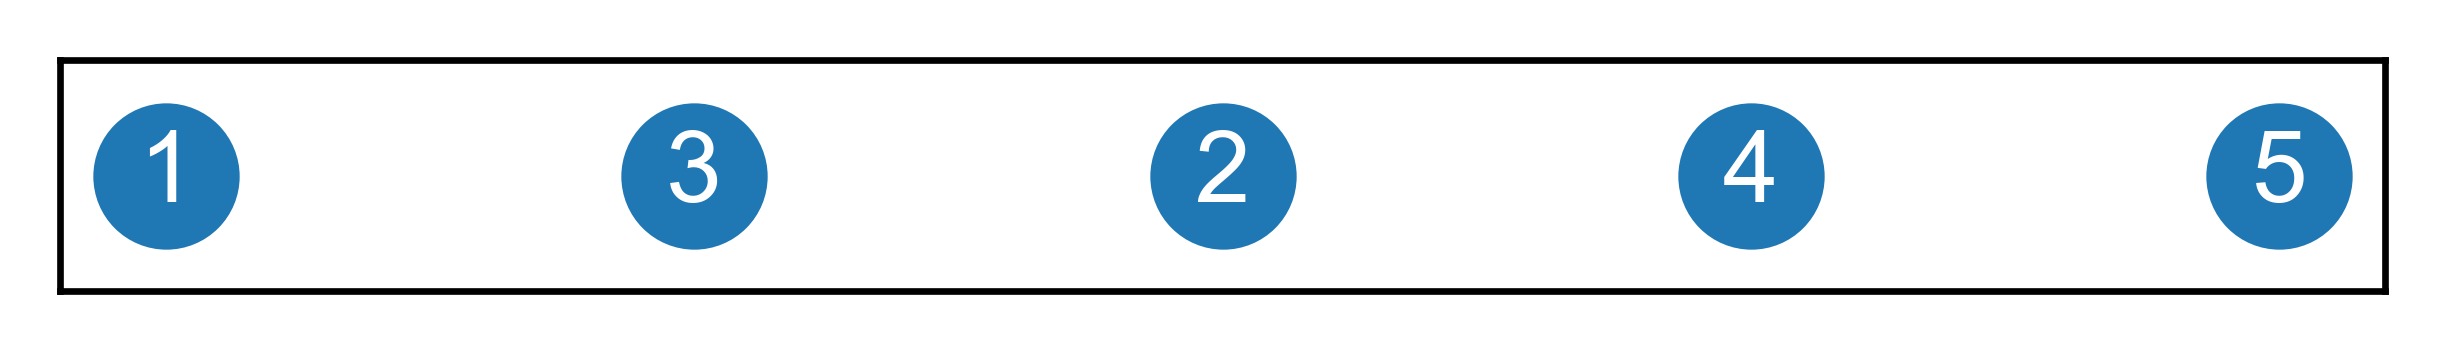

In [10]:
traj = nx.DiGraph()
for i in range(5):
    traj.add_node(i+1)
traj.add_edge(1, 3, label='R')
traj.add_edge(3, 2, label='L')
traj.add_edge(2, 2, label='R')
traj.add_edge(2, 4, label='L')
traj.add_edge(4, 5, label='L')
traj.add_edge(5, 5, label='L')


fig_width = 5
buffer = 0.5
buffered_fig_width = fig_width - 2 * buffer
fig_height = 0.5
pos = {i: (i * buffered_fig_width/6 + buffer, 0) for i in range(1, 6)}
pos[2] = (3 * buffered_fig_width/6 + buffer, 0)
pos[3] = (2 * buffered_fig_width/6 + buffer, 0)
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=600)
nx.draw_networkx_nodes(traj, pos, ax=ax, node_size=300)
nx.draw_networkx_labels(traj, pos, ax=ax, font_size=12, font_color='white')

In [14]:
def plot_trace(rates, IappE, ax1, ax2):
    # new_rates should contain the rates of both units in each pair, in order
    new_rates = np.zeros((2*numPairs, raw_time_len))
    for i in range(numPairs):
        new_rates[2*i] = rates[i, 0]
        new_rates[2*i + 1] = rates[i, 1]
    # plot firing rates
    vals = ax1.imshow(new_rates[:, :], cmap = 'afmhot', interpolation='nearest', aspect='auto', vmin=0, vmax= int(np.max(new_rates))+1)
    ax1.set_ylabel("Unit ID")
    ax1.set_yticks(np.arange(0.5, 2*numPairs, 2), labels=np.arange(numPairs), minor=False)
    ax1.grid(which='minor', color='k', linestyle='-', linewidth=2)
    ax1.set_xticks(np.arange(0, raw_time_len, int(1/dt)), labels=[])
    ax1.tick_params(which='minor', length=0)
    cb = fig.colorbar(vals, ax=ax1, fraction=0.046, pad=0.04, label="Firing Rate (Hz)")

    # plot Iapp
    x2ticks = np.arange(0, raw_time_len, int(2/dt))
    ax2.set_xticks(x2ticks, labels = np.round(np.linspace(0, raw_time_len*dt, len(x2ticks)), 1))
    ax2.plot(IappE[0])
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("$I_{app}$")

In [41]:
def plot_reliabilities(ax, fname):
    # load reliabilities
    reliabilities = np.load(fname)
    # set axes (manually set)
    amp_range = np.logspace(0, 2, 50)
    dur_range = np.linspace(0, 0.1, 50)
    dur_mesh, amp_mesh = np.meshgrid(dur_range, amp_range) # amp on y-axis, duration on x-axis
    
    # plot
    c = ax.pcolormesh(dur_mesh, amp_mesh, reliabilities.reshape(dur_mesh.shape), cmap='viridis', shading='auto')
    ax.set_yscale('log')
    ax.set_xlabel(r"$\tau_{dur}$")
    ax.set_ylabel(r"$I_{app}$")
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Reliability')

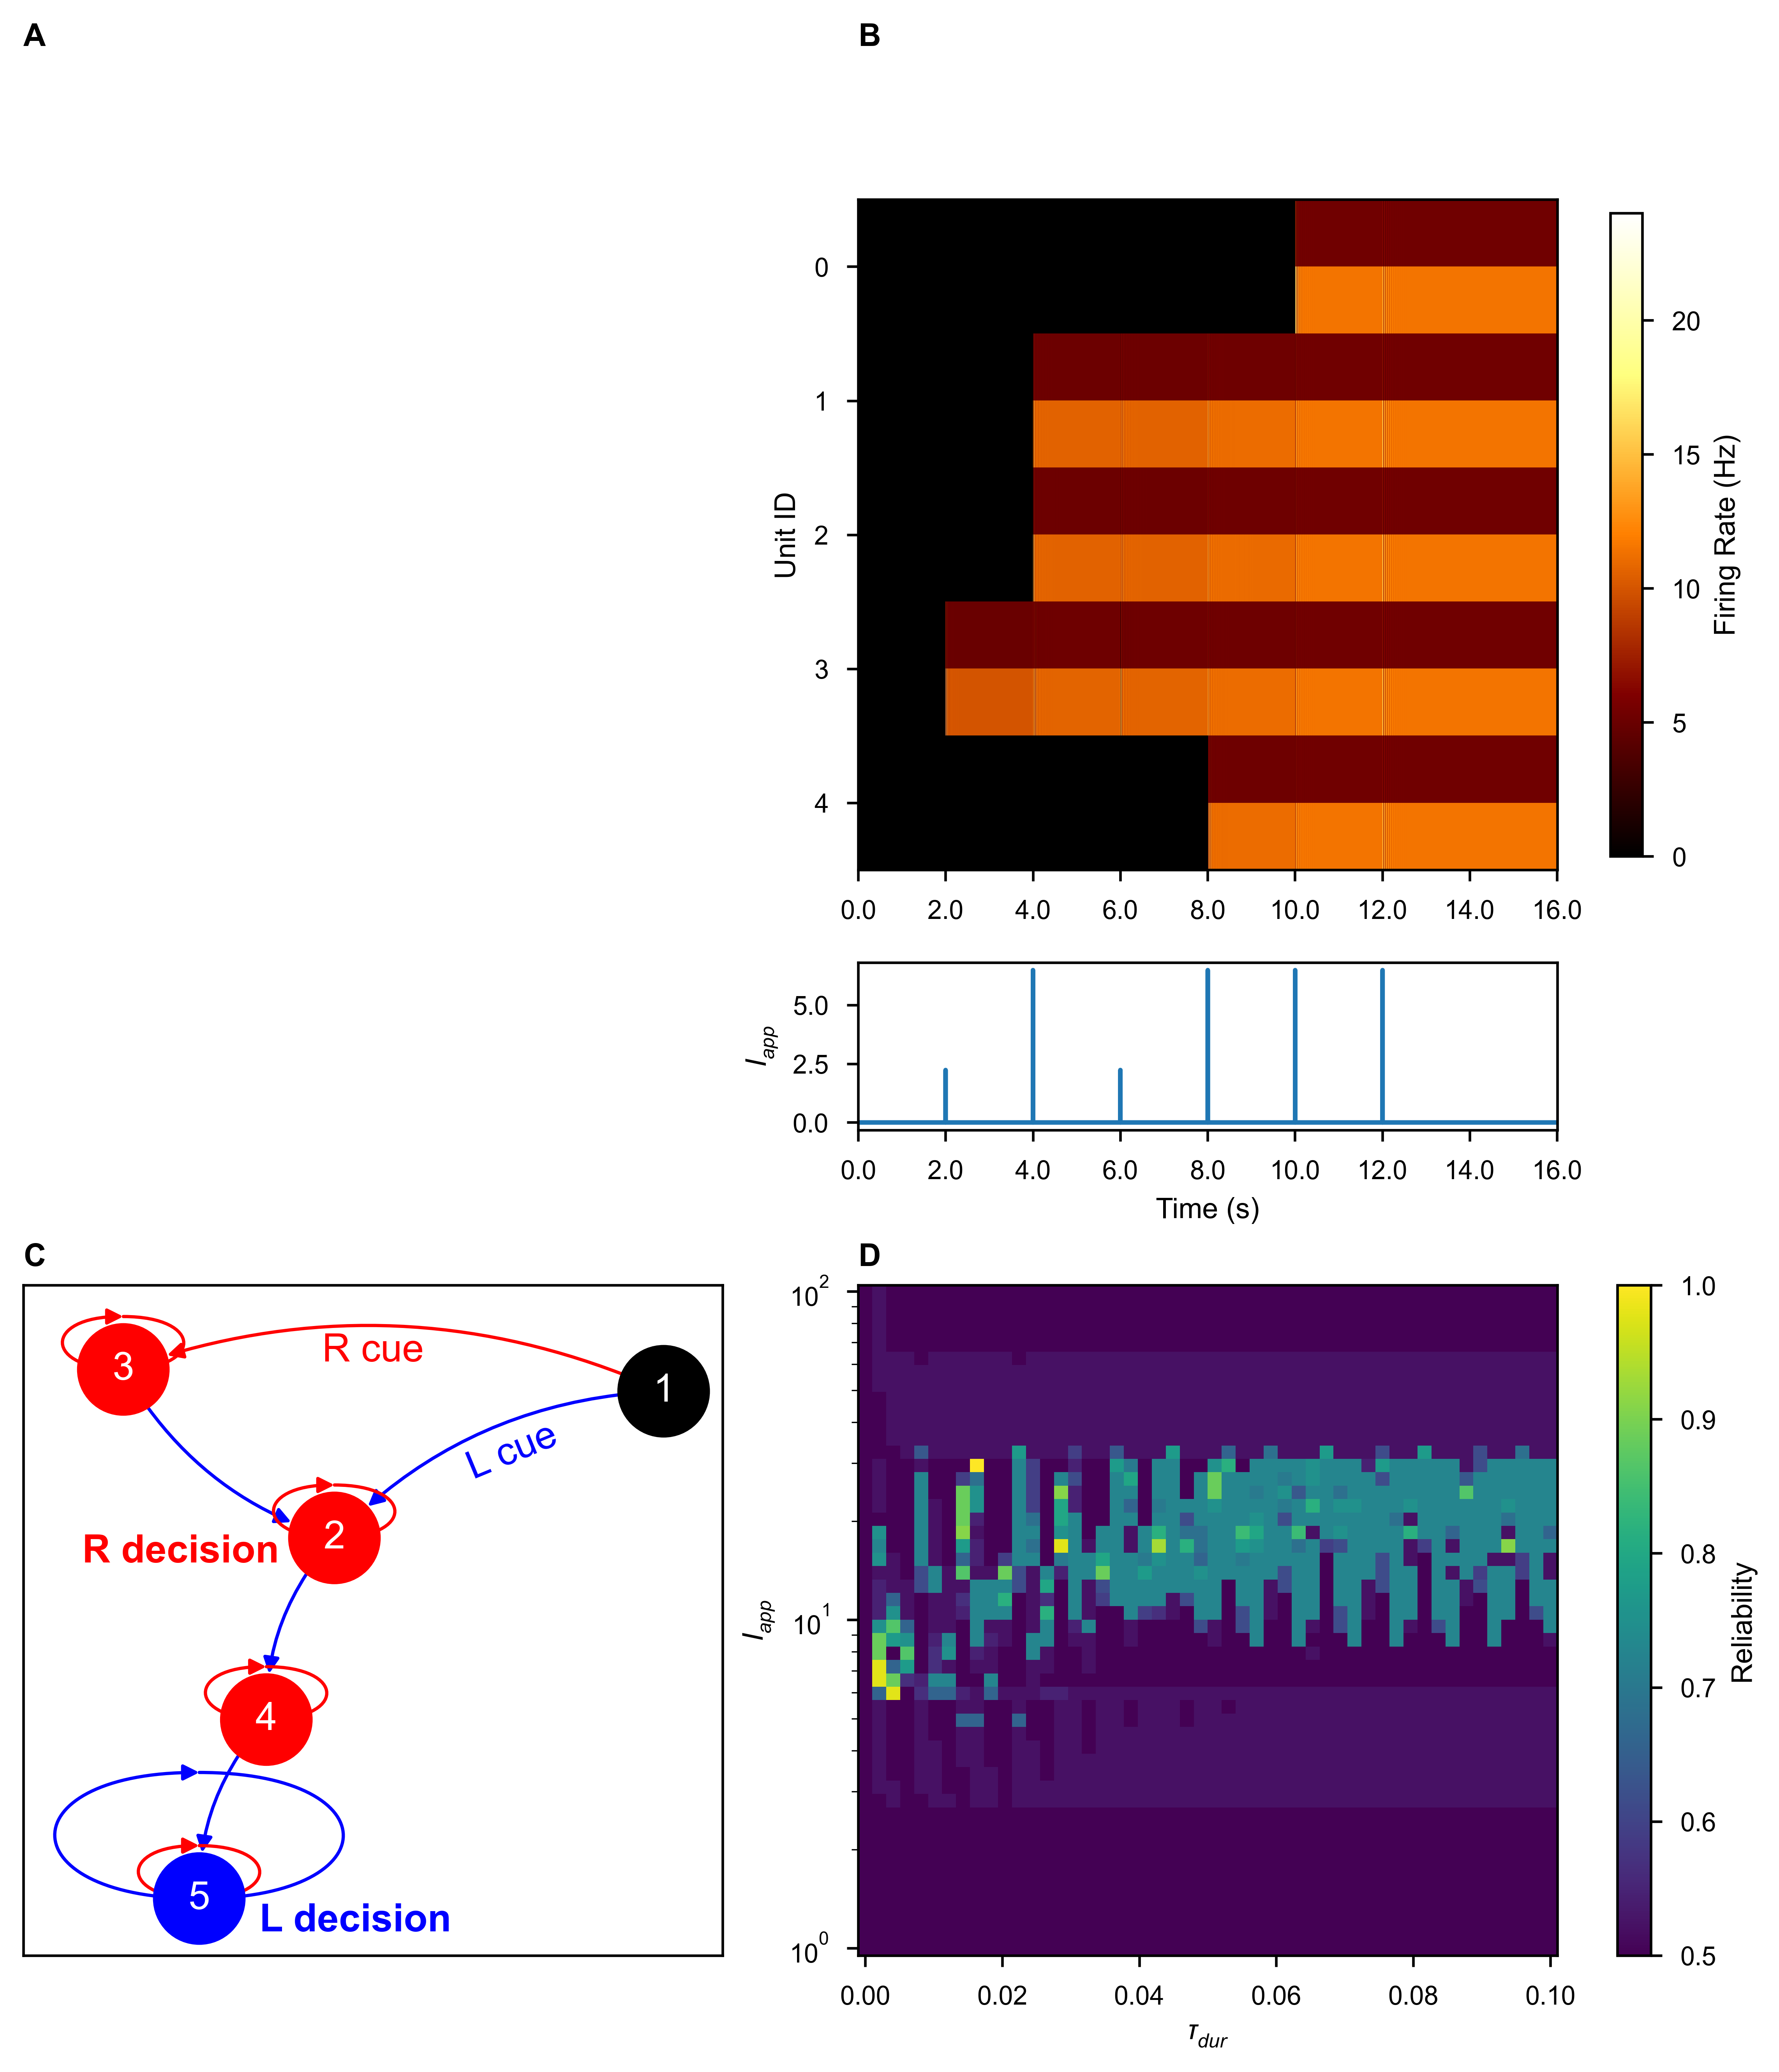

In [51]:
px = 1/plt.rcParams['figure.dpi']   # convert pixel to inches
fig = plt.figure(layout='constrained', figsize=(MAX_WIDTH*px, MAX_HEIGHT*px))
axd = fig.subplot_mosaic(
    """
    AB
    Ab
    Ac
    CD
    """,
    height_ratios=[0.25,4,1,4]
)
for label, ax in axd.items():
    if label in ('b', 'c'): continue
    ax.set_title(label, loc='left', fontweight='bold')
axd['A'].axis('off')    # hide A
axd['B'].axis('off')    # hide B
# share axes between b and c
axd['b'].sharex(axd['c'])

# plot trace ------------------------------------------------------------
plot_trace(rates, IappE, axd['b'], axd['c'])

# plot FSM ------------------------------------------------------------
plot_FSM(FSM, axd['C'], connection_map={'L': 'arc3,rad=0.2', 'R': 'arc3,rad=0.2'})
# add a label in the bottom right corner
axd['C'].text(0.5, 0.875, 'R cue', transform=axd['C'].transAxes, ha='center', va='bottom', 
              fontsize=plt.rcParams['font.size'], c='red')
axd['C'].text(0.7, 0.7, 'L cue', transform=axd['C'].transAxes, ha='center', va='bottom', 
              fontsize=plt.rcParams['font.size'], c='blue', rotation=22.5)
axd['C'].text(0.225, 0.575, 'R decision', transform=axd['C'].transAxes, ha='center', va='bottom', 
              fontsize=plt.rcParams['font.size'], c='red', weight='semibold')
axd['C'].text(0.475, 0.025, 'L decision', transform=axd['C'].transAxes, ha='center', va='bottom', 
              fontsize=plt.rcParams['font.size'], c='blue', weight='semibold')
# plot reliabilities ------------------------------------------------------------
plot_reliabilities(axd['D'], r'..\figures\figure3\reliabilities_2.npy')

plt.show()
